# Hypergraph-of-Entity - Characterization

## Representation

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-3t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_3t_nl-degree \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_3t_nl/base` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly.

In [1]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    logging,
    ggplot2,
    scales,
    repr
)

basicConfig()
options(warn=-1)
options(repr.plot.width=10, repr.plot.height=4)

base_dir <- "data/inex_2009_3t_nl/base"

Loading required package: pacman


We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [2]:
plot_degree_per_type <- function(data, label) {
    data <- split(data, data$Type)
    data <- lapply(data, function(d) {
      cbind(
          Type=d$Type[1],
          setNames(as.data.frame(table(d$Degree)), c("Degree", "Freq")))
    })
    data <- do.call(rbind, data)
    data$Degree <- as.numeric(as.character(data$Degree))

    ggplot(data, aes(x=Degree, y=Freq)) +
        facet_wrap(~Type) +
        geom_point(size=1) +
        #stat_smooth(method = "lm") +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [3]:
load_degree_data <- function(base_dir) {
    nodes <- read.csv(paste(base_dir, "global/node-degree-20190322T110458.csv", sep="/"), stringsAsFactors = F)
    edges <- read.csv(paste(base_dir, "global/edge-degree-20190322T111050.csv", sep="/"), stringsAsFactors = F)
    
    nodes[which(nodes$Type == "EntityNode"), "Type"] <- "entity"
    nodes[which(nodes$Type == "TermNode"), "Type"] <- "term"

    edges[which(edges$Type == "DocumentEdge"), "Type"] <- "document"
    edges[which(edges$Type == "ContainedInEdge"), "Type"] <- "contained_in"
    edges[which(edges$Type == "RelatedToEdge"), "Type"] <- "related_to"
    edges[which(edges$Type == "SynonymEdge"), "Type"] <- "synonym"
    edges[which(edges$Type == "ContextEdge"), "Type"] <- "context"
    
    list(nodes=nodes, edges=edges)
}

### Degree Distributions

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [4]:
degree <- load_degree_data(base_dir)

As we can see, the node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

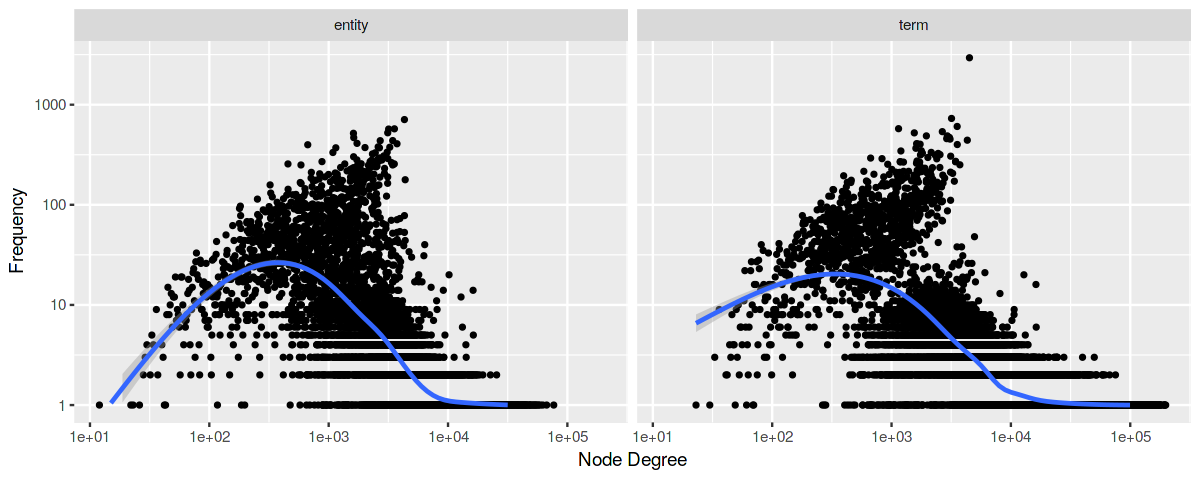

In [5]:
plot_degree_per_type(degree$nodes, "Node Degree") + stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

On the other hand, the hyperedge degree distributions all follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

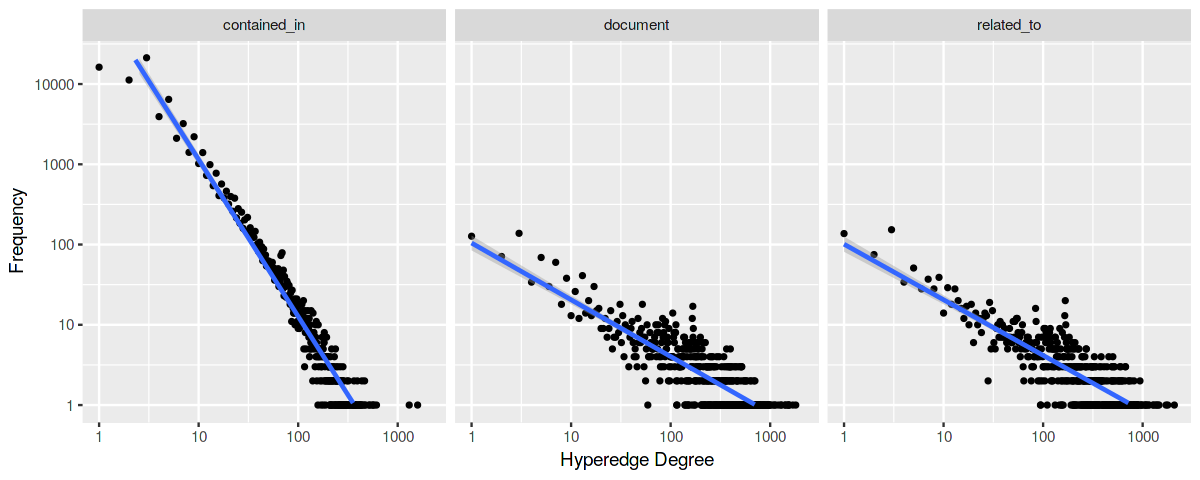

In [7]:
plot_degree_per_type(degree$edges, "Hyperedge Degree") + stat_smooth(method="lm")

### Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree
- Average hyperedge degree
- Average path length